# GEOS 518: Applied Hydrologic Science
# Module 04: Autoregressive Models with Hydrologic Time Series

## By: Lejo Flores
## January 26, 2018

In this notebook...

## 1. Load the required libraries, load the data, and double-check it

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as sm
from pandas.core import datetools

# Load the Henry's fork discharge dataset
df = pd.read_pickle('../data/HenrysForkDischarge_WY2001-2015.pkl')

# Create a Water Year column for our pandas data frame. This is a pretty 
# simple thing to do, but may not be necessary if you're not dealing with
# discharge data. Here's how it goes:
# 1. Create an empty array that is full of zeros and equal in length to 
#    the number of days in the record
WY = np.zeros(len(df['Y'].index)) 
# 2. For those records where the month is less than 10, their associated 
#    year is the correct water year
WY[df['M'].values < 10] = df['Y'].values[df['M'].values < 10] 
# 3. For those records where the month is greater than or equal to 10, 
#    the correct water year is one more than the current calendar year
WY[df['M'].values >= 10] = df['Y'].values[df['M'].values >= 10] + 1
# 4. Save the water year array as a column in the pandas data frame, as an
#    integer
df['WY'] = WY.astype(int)

# Print the first and last 10 records just to make sure we loaded the data okay
qrows = np.concatenate([np.arange(0,10,1),np.arange(-11,-1,1)])
df.iloc[qrows,:]

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,Y,M,D,Q,SerDates,WY
0,2000,10,1,39.361853,2000-10-01,2001
1,2000,10,2,39.361853,2000-10-02,2001
2,2000,10,3,37.945959,2000-10-03,2001
3,2000,10,4,37.945959,2000-10-04,2001
4,2000,10,5,37.379601,2000-10-05,2001
5,2000,10,6,36.813243,2000-10-06,2001
6,2000,10,7,37.096422,2000-10-07,2001
7,2000,10,8,36.813243,2000-10-08,2001
8,2000,10,9,38.512316,2000-10-09,2001
9,2000,10,10,37.662780,2000-10-10,2001


## 2. Split the dataframe into a training and test portion

Often in data-driven modeling, it's a good idea to reserve a portion of your data for building the model and another portion for testing that built model against the developed model. This is generically referred to as "cross validation" and there are many, many ways to do it. The philosophy is that you won't really how robust your statistical model is if you're using all of the data to develop that model. Rather, it's good practice to build your model with some fraction of the data and test how well it does in predicting the other fraction. It's an even better practice to repeat this process many, many (maybe millions of times). This process might look like: 
1. Randomly select some fraction of the data to be used in building the model - in time series analysis we typically require these fractions to be continuous. We will call this the training or "in-bag" sample.
2. Set the other fraction of data aside for testing the developed model. This fraction is known as the test or "out-of-bag" sample.
3. Build the model with the training fraction and save the coefficients of the model (e.g., $\mu$, $\phi_1$, etc.)
4. Using the indepdent variables contained within the out-of-bag/test dataset, apply the model to make predictions of the dependent variable in the out-of-bag/test sample
5. Compare the prediction against the observed values for the out-of-bag/test dataset and compute any error metrics like root mean squared error, bias, $R^2$, etc.
6. Save the parameters and repeat steps 1-5 many times
7. Characterize the many values of the model parameters from 6 using measures like the average parameter values, the variance in parameter values, histograms of parameter values, etc.

In this case, we will be doing a relatively simple cross-validation exercise in which we split the model into the first 14 years of record, which we will use for model development, and test that model against the final year of data.

In [2]:
# In the following example, we're going to segment the whole dataframe
# into a training dataset (everything that's not Water Year 2015) and
# a test dataset (everything that is Water Year 2015).
df_train = df[df.WY != 2015]
df_test  = df[df.WY == 2015]


## 3. Examine the Structure of the Partial Autocorrelation Function in the Data

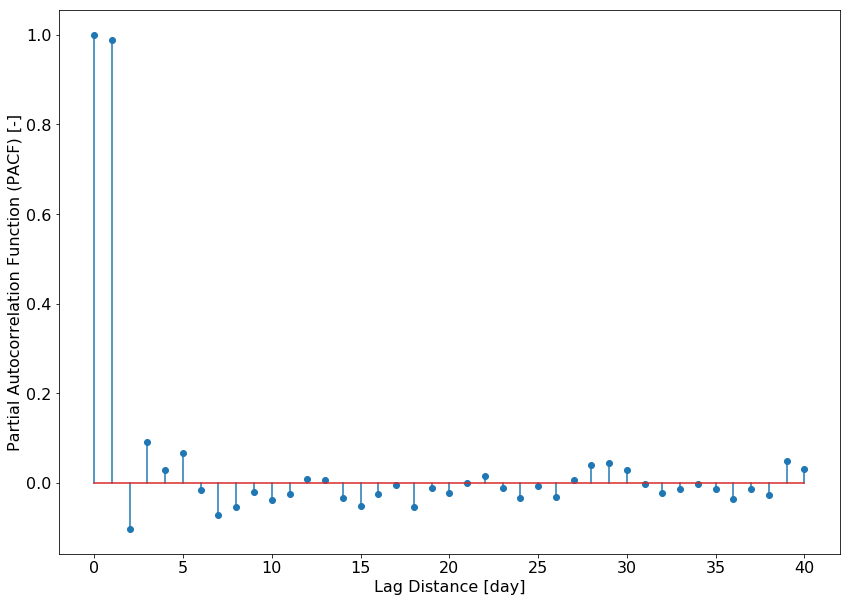

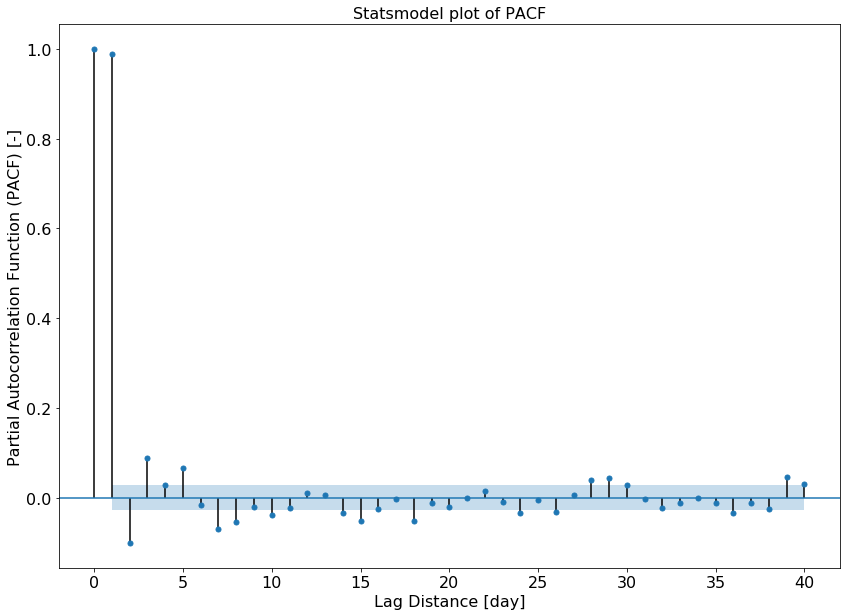

In [3]:
Qt = pd.Series(df_train['Q'].values,df_train['SerDates'].values)

Qpacf = sm.pacf(Qt)

plt.figure(figsize=(14,10))
plt.stem(Qpacf)
plt.ylabel('Partial Autocorrelation Function (PACF) [-]',fontsize=16)
plt.xlabel('Lag Distance [day]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

from statsmodels.graphics.tsaplots import plot_pacf
f, axarr = plt.subplots(1, 1, figsize=(14,10))
_ = plot_pacf(Qt,method='ols',lags=40,ax=axarr.axes)
axarr.set_title('Statsmodel plot of PACF',fontsize=16)
axarr.set_ylabel('Partial Autocorrelation Function (PACF) [-]',fontsize=16)
axarr.set_xlabel('Lag Distance [day]',fontsize=16)
axarr = plt.gca()
axarr.tick_params('both',labelsize=16)


## 4. Fit AR(1) and AR(2) Models to the Data

In [4]:
Q_AR1_model = sm.AR(Qt).fit(1)
print(Q_AR1_model.params)

const    0.502767
L1.y     0.987884
dtype: float64


In [5]:
Q_AR2_model = sm.AR(Qt).fit(2)
print(Q_AR2_model.params)

const    0.554079
L1.y     1.088064
L2.y    -0.101412
dtype: float64


## 5. Use the Developed Model to Make Predictions of the Test Data

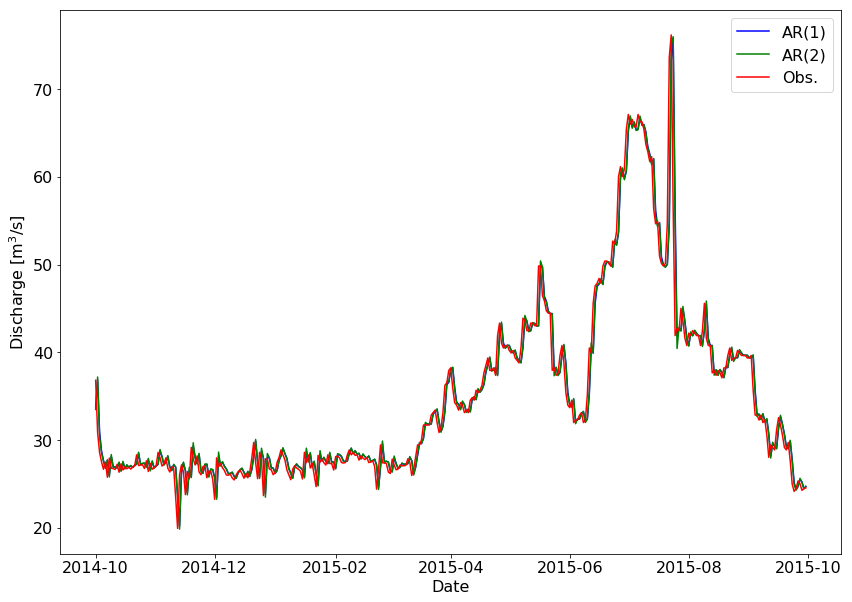

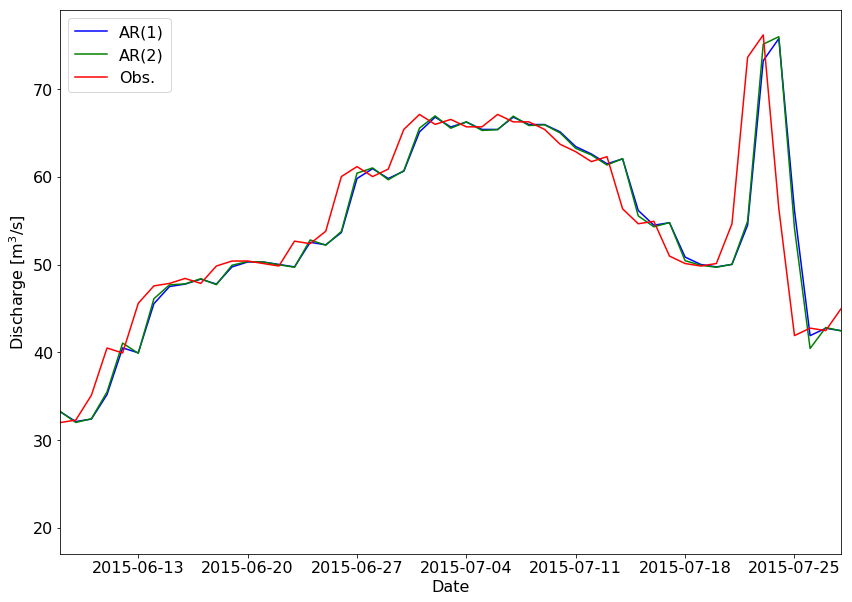

In [6]:
Qtrain = df_train['Q'].values
Qtest  = df_test['Q'].values

DatesTest = df_test['SerDates'].values

Qttm1 = np.concatenate([Qtrain[-2:-1],Qtest[0:-1]])
Qttm2 = np.concatenate([Qtrain[-3:-1],Qtest[0:-2]])

AR1_mu   = Q_AR1_model.params[0]
AR1_phi1 = Q_AR1_model.params[1]

QhatAR1 = AR1_mu + AR1_phi1*Qttm1

AR2_mu   = Q_AR2_model.params[0]
AR2_phi1 = Q_AR2_model.params[1]
AR2_phi2 = Q_AR2_model.params[2]

QhatAR2 = AR2_mu + AR2_phi1*Qttm1 + AR2_phi2*Qttm2

plt.figure(figsize=(14,10))

plt.plot(DatesTest,QhatAR1,'b-')
plt.plot(DatesTest,QhatAR2,'g-')
plt.plot(DatesTest,Qtest,'r-')
plt.ylabel('Discharge [m${}^3$/s]',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('AR(1)','AR(2)','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

plt.figure(figsize=(14,10))
plt.plot(DatesTest,QhatAR1,'b-')
plt.plot(DatesTest,QhatAR2,'g-')
plt.plot(DatesTest,Qtest,'r-')
plt.xlim([DatesTest[250],DatesTest[300]])
plt.ylabel('Discharge [m${}^3$/s]',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('AR(1)','AR(2)','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

## 6. Compare the Predictions with Observations

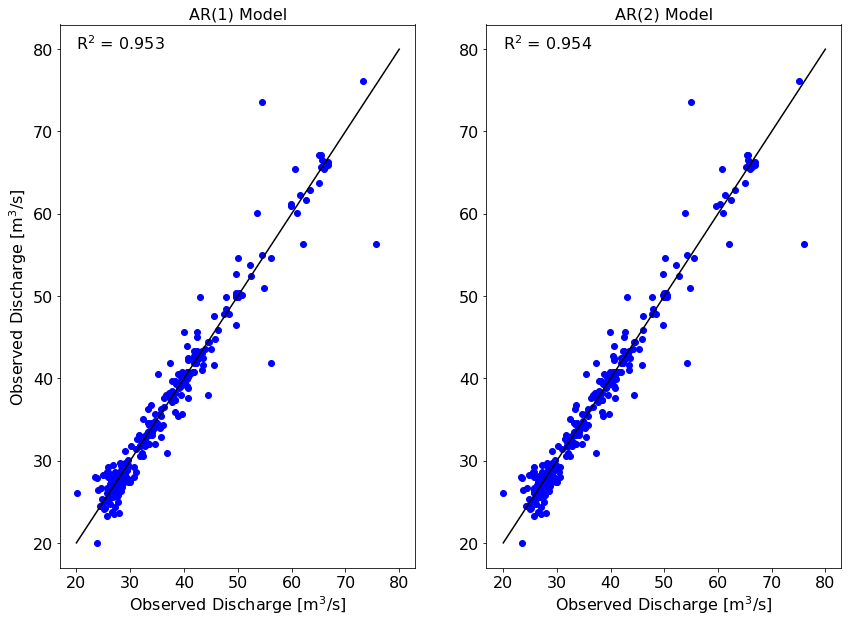

In [7]:
# Compute the R^2 values for each prediction 
R2AR1 = np.corrcoef(QhatAR1,Qtest)**2
R2AR2 = np.corrcoef(QhatAR2,Qtest)**2


# Plot the AR(1) and AR(2) model results 
plt.figure(figsize=(14,10))
plt.subplot(121)
plt.plot(QhatAR1,Qtest,'bo')
plt.plot([20, 80], [20, 80], 'k-')
plt.title('AR(1) Model',fontsize=16)
plt.ylabel('Observed Discharge [m${}^3$/s]',fontsize=16)
plt.xlabel('Observed Discharge [m${}^3$/s]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2AR1[0,1], xy=(20,80), fontsize=16)

plt.subplot(122)
plt.plot(QhatAR2,Qtest,'bo')
plt.plot([20, 80], [20, 80], 'k-')
plt.title('AR(2) Model',fontsize=16)
plt.xlabel('Observed Discharge [m${}^3$/s]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2AR2[0,1], xy=(20,80), fontsize=16)

plt.show()
